<a href="https://colab.research.google.com/github/Jominhee06/home_big-2/blob/main/%EC%BD%94%EB%93%9C%EC%9E%90%EB%A3%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AWS Deepracer — How to train a model in 15 minutes

- 원본 자료
  - https://falktan.medium.com/aws-deepracer-how-to-train-a-model-in-15-minutes-a07ab77fb793
  - https://github.com/TwoDigits/deepracer/blob/master/reward_function.py

- 아래코드는 위 코드를 수정 보완한 코드

In [ ]:
import math

# 두 점 사이의 거리를 구하는 함수
def dist(point1, point2):
    return ((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2) ** 0.5

# 어떤 점의 원점으로 부터의 거리와 각도를 계산해주는 함수
def polar(x, y):
    r = (x ** 2 + y ** 2) ** .5
    theta = math.degrees(math.atan2(y,x))
    return r, theta

# 각도를 -180 ~ 180 사이로 만들어주는 함수
def angle_mod_360(angle):
    n = math.floor(angle/360.0)
    angle_between_0_and_360 = angle - n*360.0
    if angle_between_0_and_360 <= 180.0:
        return angle_between_0_and_360
    else:
        return angle_between_0_and_360 - 360

# 웨이포인트의 점 사이를 촘촘하게 채운 새로운 웨이포인트를 계산
def up_sample(waypoints, factor):
    p = waypoints
    n = len(p) - 1   # 순환트랙
    up_sample_waypoints = []

    for j in range(n):
        for i in range(factor):
            x = i / factor * p[(j+1) % n][0] + (1 - i / factor) * p[j][0]
            y = i / factor * p[(j+1) % n][1] + (1 - i / factor) * p[j][1]
            up_sample_waypoints.append([x, y])

    return up_sample_waypoints

# 타겟 포인트를 구하는 함수
def get_target_point(params):
    up_sample_waypoints = up_sample(params['waypoints'], 20)
    car = [params['x'], params['y']]

    # 가장 가까운 웨이포인트의 인덱스 찾기
    distances = [dist(p, car) for p in up_sample_waypoints]
    min_dist = min(distances)
    i_closest = distances.index(min_dist)

    # 트랙 너비의 90% 길이를 원의 반지름으로 설정
    r = params['track_width'] * 0.9

    # 타겟 포인트 찾기
    n = len(up_sample_waypoints)
    for i in range(i_closest, i_closest + n) :
        target_index = i % n
        target_point = up_sample_waypoints[target_index]
        if dist(target_point, car) > r:
            break

    return target_point

# 타겟 포인트와 해딩 각의 차이 (최적의 핸들 각도)를 구하는 함수
def get_target_steering_degree(params):
    tx, ty = get_target_point(params)
    car_x = params['x']
    car_y = params['y']
    dx = tx-car_x
    dy = ty-car_y
    heading = params['heading']

    _, target_angle = polar(dx, dy)

    steering_angle = target_angle - heading

    return angle_mod_360(steering_angle)

# 최적의 핸들 각도와 현재 핸들 각도의 차이에 따라 다르게 보상
def reward_function(params):
    best_steering_angle = get_target_steering_degree(params)
    steering_angle = params['steering_angle']

    error = (steering_angle - best_steering_angle) / 60.0

    score = 1.0 - abs(error)
    reward = max(score, 0.01)
    return float(reward)

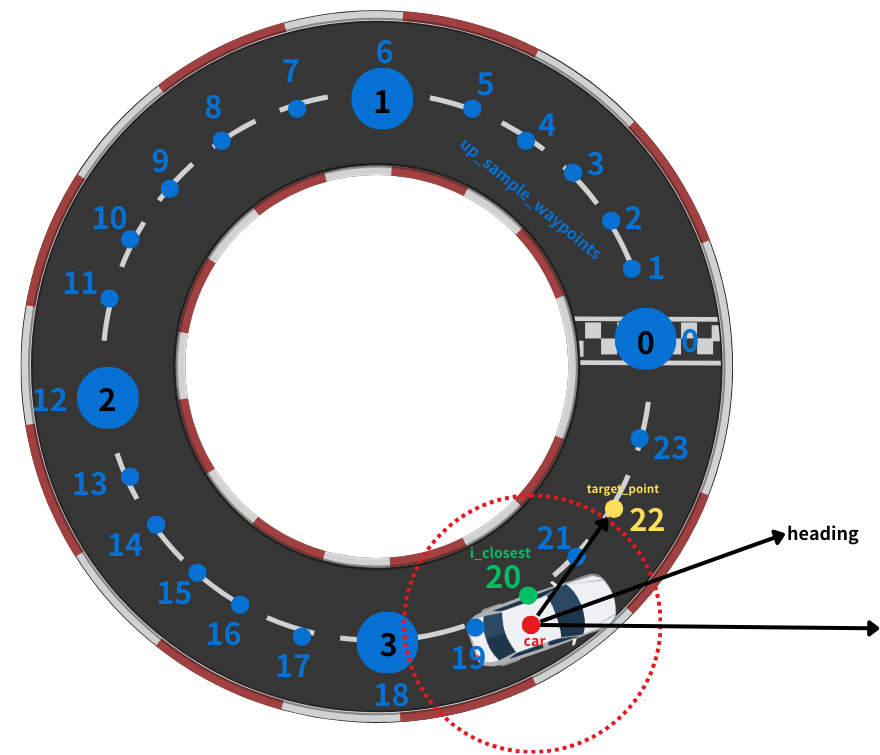